## Install dependencies
- `fastai` - machine learning library
- `soudnfile` - open `.wav` files as `numpy` arrays
- `matplotlib` - plot waveforms
- `torchaudio` - tools for training audio models
- `torchvision` - tools for training machine vision models, also useful more generally

In [5]:
!pip3 install fastai soundfile matplotlib torchaudio torchvision

## Download the training dataset

Source: https://magenta.tensorflow.org/datasets/nsynth

We only download the test set, of 4096 examples rather than the substantially larger training set. Download to the `training-data` directory in the root of the repository, so it can be shared by other projects and it is also part of `.gitignore`.

In [7]:
import requests

url = 'http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz'
response = requests.get(url)

with open('../../training-data/nsynth-test.jsonwav.tar.gz', 'wb') as f:
    f.write(response.content)

## Extract the downloaded dataset

In [8]:
import tarfile

with tarfile.open('../../training-data/nsynth-test.jsonwav.tar.gz', 'r:gz') as f:
    f.extractall('../../training-data/')

## Load the example metadata

The metadata is located in `examples.json` in the extracted directory.

In [9]:
import json
import itertools

examples = []
with open('../../training-data/nsynth-test/examples.json') as f:
    examples = json.load(f)

first_example = list(examples.items())[0]

## Plot the first waveform

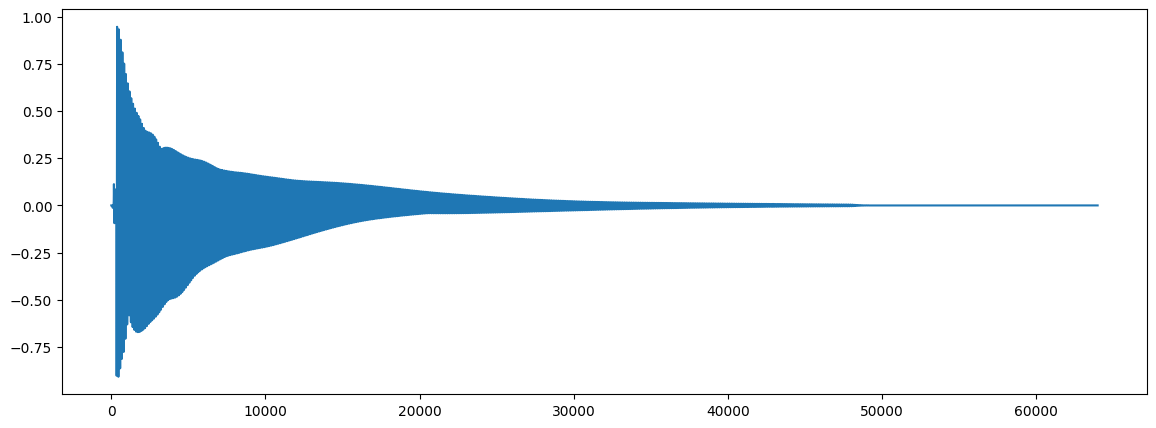

In [11]:
import soundfile as sf
import matplotlib.pyplot as plt

y, _ = sf.read('../../training-data/nsynth-test/audio/' + first_example[0] + '.wav')

plt.figure(figsize=(14, 5))
plt.plot(y)
plt.show()

## Create the DataLoaders

In [12]:
from fastai.vision.all import *
import torchaudio

def get_audio_files(path):
    return L(os.path.join(path, f) for f in os.listdir(path) if f.endswith('.wav'))

class CustomAudioBlock(TransformBlock):
    def __init__(self):
        type_tfms = partial(self.create)
        return super().__init__(type_tfms=type_tfms, batch_tfms=IntToFloatTensor)

    def create(self, fn: Path):
        x, _ = torchaudio.load(fn)
        x = x.reshape(1, 1, 64000)
        return x

dls = DataBlock(
    blocks=(CustomAudioBlock(), CategoryBlock()),
    get_items=get_audio_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: examples[os.path.basename(x)[:-4]]['instrument_family_str']
).dataloaders("../../training-data/nsynth-test/audio/", bs=64)

## Display one waveform from a test batch

string


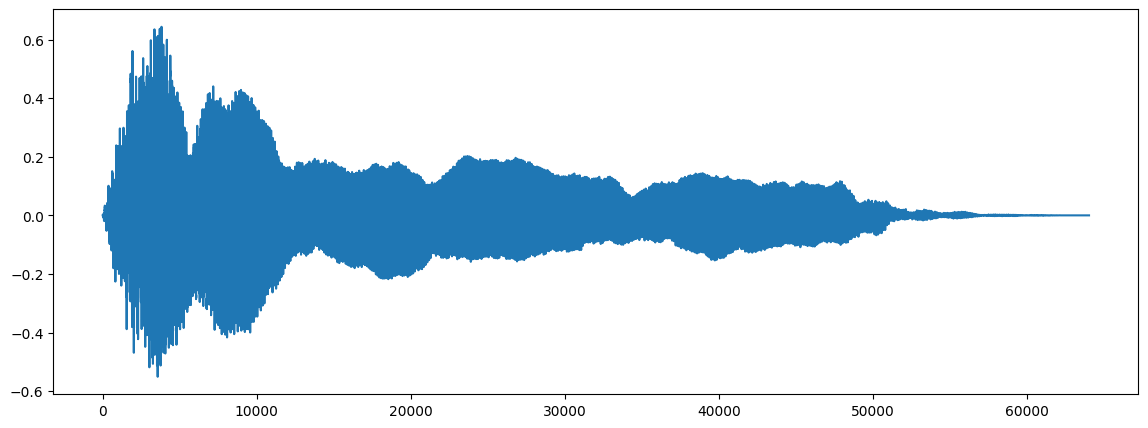

In [13]:
waveforms, categories = dls.one_batch()

print(dls.vocab[categories[0].item()])

plt.figure(figsize=(14, 5))
plt.plot(waveforms[0].reshape(-1))
plt.show()

In [14]:
def custom_resnet18(pretrained=True, progress=True, **kwargs):
    model = resnet18(pretrained, progress, **kwargs)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

learn = vision_learner(
    dls=dls,
    arch=custom_resnet18,
    metrics=error_rate
)

learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.897467,2.321708,0.739927,13:14
1,2.114609,1.176244,0.401709,13:15
2,1.580658,0.826541,0.280830,13:17
3,1.243929,0.679266,0.234432,13:12
4,1.037367,0.616711,0.195360,13:10
5,0.856929,0.524801,0.167277,13:14
6,0.729096,0.478664,0.162393,13:13
7,0.658129,0.469979,0.156288,13:14
8,0.597277,0.460542,0.148962,13:12
9,0.569218,0.434967,0.152625,13:13


In [17]:
learn.save('audio-classifier')

Path('models/audio-classifier.pth')

In [27]:
waveforms, categories = dls.one_batch()

for i in range(64):
    prediction, _, _ = learn.predict(waveforms[i])

    predicted_category = prediction
    actual_category = dls.vocab[categories[i].item()]

    print(f'Predicted: {predicted_category}, Actual: {actual_category}')

/anaconda/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Predicted: organ, Actual: organ


Predicted: bass, Actual: bass


Predicted: string, Actual: brass


Predicted: string, Actual: organ


Predicted: keyboard, Actual: guitar


Predicted: organ, Actual: organ


Predicted: guitar, Actual: guitar


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: keyboard, Actual: keyboard


Predicted: keyboard, Actual: keyboard


Predicted: keyboard, Actual: keyboard


Predicted: brass, Actual: brass


Predicted: bass, Actual: bass


Predicted: keyboard, Actual: keyboard


Predicted: string, Actual: keyboard


Predicted: organ, Actual: organ


Predicted: organ, Actual: organ


Predicted: guitar, Actual: guitar


Predicted: keyboard, Actual: guitar


Predicted: bass, Actual: bass


Predicted: reed, Actual: reed


Predicted: string, Actual: string


Predicted: keyboard, Actual: keyboard


Predicted: organ, Actual: organ


Predicted: flute, Actual: flute


Predicted: mallet, Actual: mallet


Predicted: keyboard, Actual: guitar


Predicted: mallet, Actual: mallet


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: brass, Actual: brass


Predicted: string, Actual: string


Predicted: reed, Actual: keyboard


Predicted: flute, Actual: flute


Predicted: keyboard, Actual: bass


Predicted: guitar, Actual: guitar


Predicted: bass, Actual: bass


Predicted: brass, Actual: brass


Predicted: brass, Actual: brass


Predicted: guitar, Actual: guitar


Predicted: bass, Actual: bass


Predicted: organ, Actual: organ


Predicted: guitar, Actual: guitar


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: brass, Actual: brass


Predicted: keyboard, Actual: keyboard


Predicted: keyboard, Actual: keyboard


Predicted: keyboard, Actual: keyboard


Predicted: guitar, Actual: guitar


Predicted: vocal, Actual: vocal


Predicted: keyboard, Actual: keyboard


Predicted: brass, Actual: brass


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: brass, Actual: string


Predicted: vocal, Actual: vocal


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: keyboard, Actual: keyboard


Predicted: keyboard, Actual: keyboard
